# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

conda install matplotlib=2.0.2  得用这个版本的matplotlib 

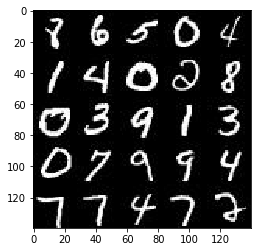

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

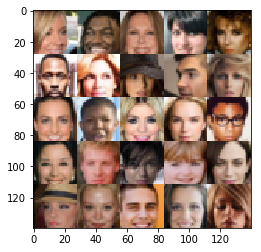

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [25]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #image shape 28 * 28 * 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #shape 14 * 14 * 64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2)#, training = True 这个暂时没加
        relu2 = tf.maximum(alpha * bn2, bn2)
        #shape 7 * 7 * 128
        
        flat = tf.reshape(relu2, (-1,7*7*128))
        logits = tf.layers.dense(flat, 1)
        outs = tf.sigmoid(logits)
        
        
    return outs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [26]:
def generator(z, out_channel_dim,is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):#注意这里对reuse的处理
        x1 = tf.layers.dense(z, 7*7*128)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #shape 7 * 7 * 128
            
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha  * x2, x2)
        #shape 14 * 14 * 64
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # shape 28 * 28 * 3
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake


    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [52]:
def train(epoch_count, batch_size, z_dim, learning_rate1, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
#     tf.reset_default_graph()
    
    input_real, input_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,  input_z: batch_z, learning_rate: learning_rate1})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,  input_z: batch_z, learning_rate: learning_rate1})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.3909... Generator Loss: 1.9479
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 1.8219
Epoch 1/2... Discriminator Loss: 2.6991... Generator Loss: 3.5646
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.3642
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 1.4996
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.3851
Epoch 1/2... Discriminator Loss: 2.6552... Generator Loss: 0.0924
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 1.5320


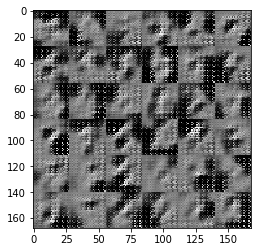

Epoch 1/2... Discriminator Loss: 4.4249... Generator Loss: 0.1431
Epoch 1/2... Discriminator Loss: 4.1359... Generator Loss: 5.2565
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 2.0933
Epoch 1/2... Discriminator Loss: 3.9924... Generator Loss: 0.1222
Epoch 1/2... Discriminator Loss: 1.5212... Generator Loss: 2.1644
Epoch 1/2... Discriminator Loss: 4.6953... Generator Loss: 0.0179
Epoch 1/2... Discriminator Loss: 4.8338... Generator Loss: 0.0199
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 3.4477
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.4195


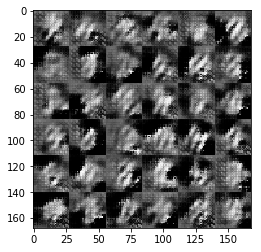

Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.3683
Epoch 1/2... Discriminator Loss: 2.7650... Generator Loss: 2.2969
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 1.0256
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 0.8187
Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 1.3804
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 0.9581
Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 1.2754
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 0.8559
Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 1.2054
Epoch 1/2... Discriminator Loss: 0.8526... Generator Loss: 1.6202


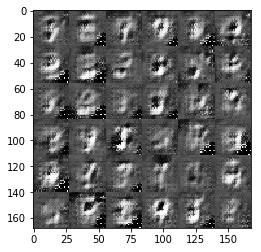

Epoch 1/2... Discriminator Loss: 0.8561... Generator Loss: 1.8404
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 1.5910
Epoch 1/2... Discriminator Loss: 3.1809... Generator Loss: 4.6774
Epoch 1/2... Discriminator Loss: 4.3687... Generator Loss: 4.4096
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 1.5944... Generator Loss: 2.3217
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.9943
Epoch 1/2... Discriminator Loss: 2.5428... Generator Loss: 3.7665
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 1.9276... Generator Loss: 0.1987


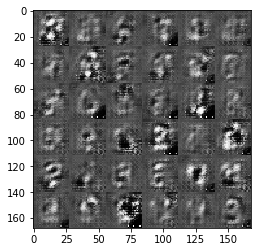

Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 2.0770
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.0896
Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 1.4713
Epoch 1/2... Discriminator Loss: 6.8686... Generator Loss: 0.0014
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.8545
Epoch 1/2... Discriminator Loss: 2.0152... Generator Loss: 2.3450
Epoch 2/2... Discriminator Loss: 1.2220... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 1.2119... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.2871
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.6026


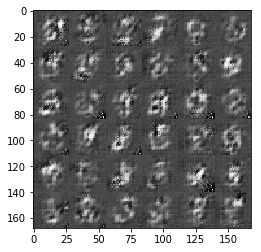

Epoch 2/2... Discriminator Loss: 1.5368... Generator Loss: 0.4419
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 1.2285
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 1.9291... Generator Loss: 0.2292
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.4121
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 0.9576... Generator Loss: 1.0956
Epoch 2/2... Discriminator Loss: 1.1214... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.4795


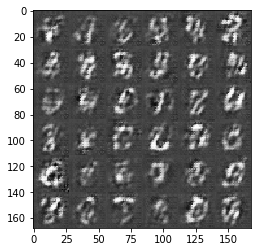

Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 1.6783... Generator Loss: 0.2786
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 1.0878
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 1.3432
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 4.0504... Generator Loss: 3.5448
Epoch 2/2... Discriminator Loss: 1.7108... Generator Loss: 0.3479
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.7393


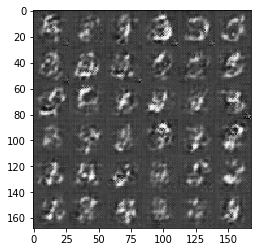

Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.3236
Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.2851
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 0.6280
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.1840... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 1.2967
Epoch 2/2... Discriminator Loss: 2.3432... Generator Loss: 0.2310


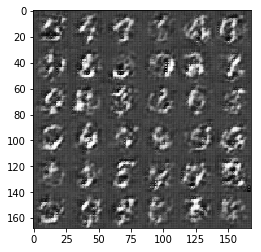

Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 1.3688
Epoch 2/2... Discriminator Loss: 0.9157... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 1.2241
Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.4273
Epoch 2/2... Discriminator Loss: 0.9796... Generator Loss: 0.9855
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.6268
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.0824


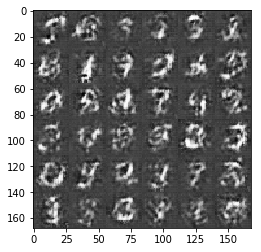

Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.7048
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.2112


In [59]:
batch_size = 128
z_dim = 100
learning_rate1 = 0.006
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate1, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 0.2524... Generator Loss: 5.7879
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.3581
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 5.2207
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 3.6799
Epoch 1/1... Discriminator Loss: 7.1730... Generator Loss: 18.9943
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 2.7430
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 4.4611
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.9612
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 2.7202


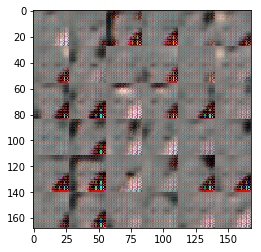

Epoch 1/1... Discriminator Loss: 1.9458... Generator Loss: 11.4846
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 4.6545
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.7957
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 3.0291
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.8775
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 2.7347
Epoch 1/1... Discriminator Loss: 3.2684... Generator Loss: 6.1052
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 5.7323
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.5130


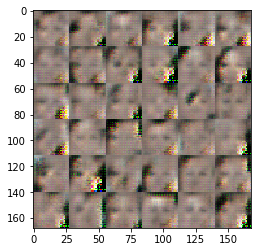

Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 2.7126
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.9389
Epoch 1/1... Discriminator Loss: 3.2840... Generator Loss: 12.3111
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 2.3984
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 2.8916
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 3.6116
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 3.1450


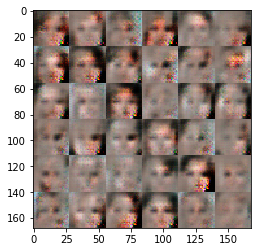

Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 2.1284
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 3.0387
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 2.8096
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 2.5545
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 2.8945
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.8423


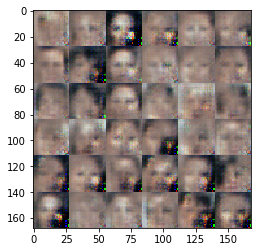

Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.9768
Epoch 1/1... Discriminator Loss: 4.0267... Generator Loss: 8.6813
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 2.6445
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 2.4648
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 1.1805
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 2.0025
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 1.7881


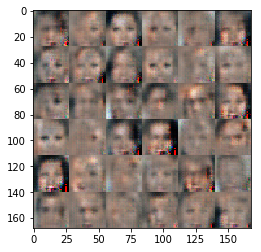

Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.9552
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 3.2343
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.6527


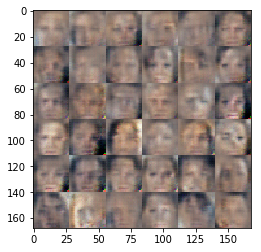

Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.7542
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 1.7953
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.4908
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.7315
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.2706


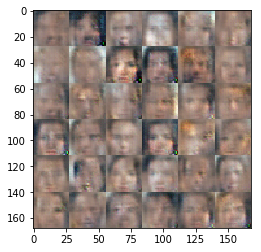

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 1.1659
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.7596... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.6134


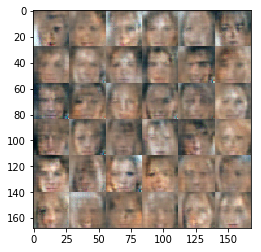

Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.5194


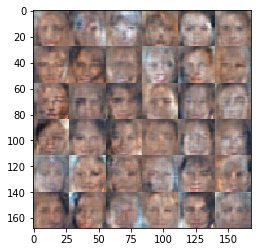

Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.7014... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.4696


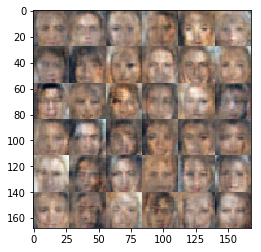

Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.6713... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 1.9499... Generator Loss: 2.1027


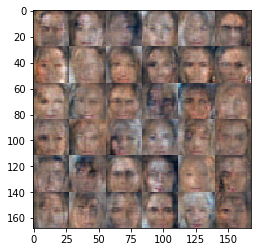

Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.3752
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6252


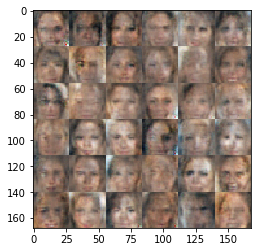

Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.8609... Generator Loss: 0.2928
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7864


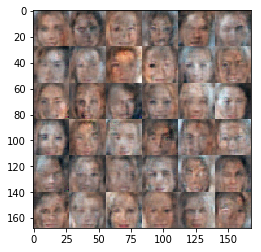

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 1.7809... Generator Loss: 0.4453
Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.3211
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.6223... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.9343


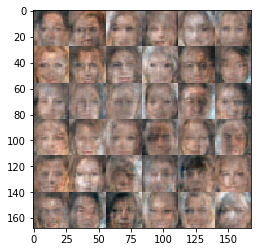

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 2.1699... Generator Loss: 0.1650
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.8172... Generator Loss: 0.9661


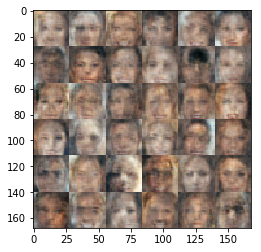

Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.7358... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.8227


In [56]:
batch_size = 128
z_dim = 100
learning_rate = 0.004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。